In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import os
from glob import glob
from sklearn.preprocessing import StandardScaler
from time import time
from sklearn.decomposition import PCA,FastICA


In [2]:
all_files_path=glob('../sd_copy/*.edf')
print(len(all_files_path))

180


In [30]:
raw = mne.io.read_raw_edf(all_files_path[3], preload=True)
raw.pick_types(meg=False, eeg=True, eog=False, ecg=False) # Selecting EEG, EOG and ECG channels

Extracting EDF parameters from e:\Department\MS\project\new\dataset and model\EEG\sd_copy\H S10 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   375.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


Measurement date,"August 17, 2011 17:51:52 GMT"
Experimenter,Unknown
Participant,Hafiz_M_0817011
Digitized points,Not available
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.00 Hz
Highpass,0.50 Hz
Lowpass,80.00 Hz


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


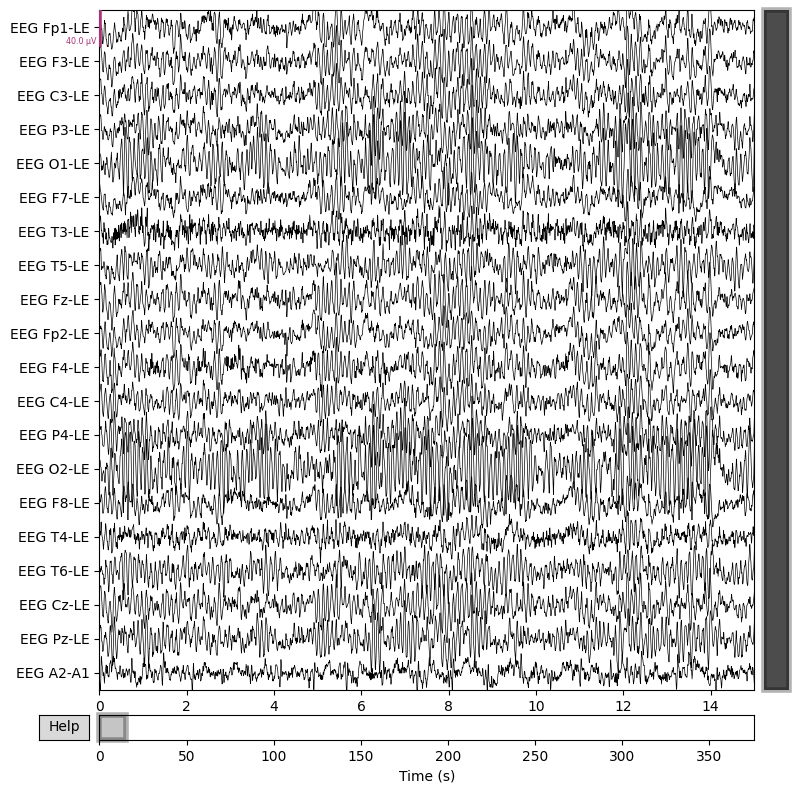

In [31]:
# Select a specific channel
channel_to_keep = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']  
# Replace with the name of the channel you want to keep
raw.pick(channel_to_keep)
raw_eeg = raw.copy()
raw_eeg.pick_types(meg=False, eeg=True, eog=True, ecg=True) # Selecting EEG, EOG and ECG channels
x=raw_eeg.plot(duration=15,n_channels=20)


In [32]:
ica_eeg = ICA(n_components=20, random_state=100) #Setup ICA <=======
ica_eeg.fit(raw_eeg) # Run ICA

Fitting ICA to data using 20 channels (please be patient, this may take a while)


Selecting by number: 20 components
Fitting ICA took 6.4s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,38 iterations on raw data (96256 samples)
ICA components,20
Available PCA components,20
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=20, n_times=96256
    Range : 0 ... 96255 =      0.000 ...   375.996 secs
Ready.


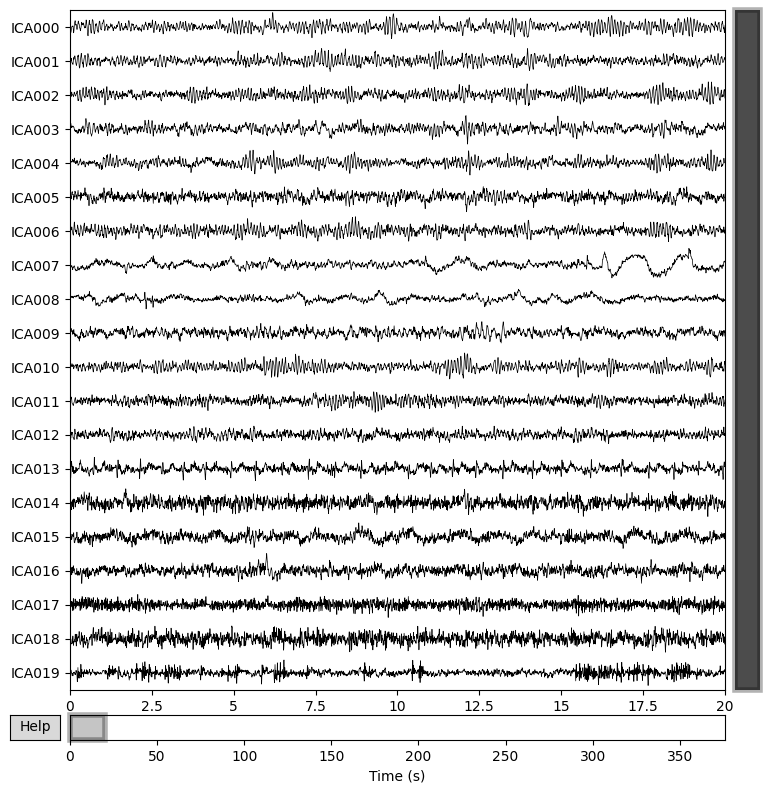

In [33]:
x = ica_eeg.plot_sources(raw_eeg) # Plot time series
# x = ica_eeg.plot_components() #Plot topographies

In [ ]:
raw_eeg.load_data()

ica_eeg.exclude = [0,1,3,9,10]  # indices chosen based on various plots above <======

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_eeg.copy()
ica_eeg.apply(reconst_raw)

#Raw
raw_eeg.plot(show=False)
plt.suptitle('Raw Time series')


#Reconstruced after removing artefactual components
reconst_raw.plot(show=False)
plt.suptitle('Cleaned Time series')
plt.show()
del reconst_raw

In [ ]:
raw.info

In [ ]:
# raw.rename_channels({'EEG Fp1-LE':'Fp1', 'EEG F3-LE':'F3', 'EEG C3-LE':'C3', 'EEG P3-LE':'P3', 'EEG O1-LE':'O1', 'EEG F7-LE':'F7', 'EEG T3-LE':'T3', 'EEG T5-LE':'T5', 'EEG Fz-LE':'Fz', 'EEG Fp2-LE':'Fp2', 'EEG F4-LE':'F4', 'EEG C4-LE':'C4', 'EEG P4-LE':'P4', 'EEG O2-LE':'O2', 'EEG F8-LE':'F8', 'EEG T4-LE':'T4', 'EEG T6-LE':'T6', 'EEG Cz-LE':'Cz', 'EEG Pz-LE':'Pz', 'EEG A2-A1':'A2', 'EEG 23A-23R':'AF3', 'EEG 24A-24R':'AF4'})

Model test


In [ ]:
lowf = 30
highf = 100
filtered_eeg = raw.filter(l_freq=lowf,h_freq=highf)


epochs = mne.make_fixed_length_epochs(filtered_eeg,duration=5,overlap=1)
data = epochs.get_data()


scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1,data.shape[-1])).reshape(data.shape)
data = np.moveaxis(data,1,2)

In [ ]:
data.shape #epoch , channel, lenght

In [ ]:
reconstructed_model = tf.keras.models.load_model("all_5s_50epoch_64batch.h5")
result=reconstructed_model.predict(data)
predict_value = np.mean(result)
predict_value


In [ ]:
if predict_value < 0.5 :
    print('MDD Patient')
    print((1-predict_value)*100)
else :
    print('Healthy') 
    print((predict_value)*100)

In [ ]:

# %%capture
# xx=[]
# for i in range(len(all_files_path)):
#     raw = mne.io.read_raw_edf(all_files_path[i], preload=True)
#     lowf = 1
#     highf = 100
#     filtered_eeg = raw.filter(l_freq=lowf,h_freq=highf)


#     epochs = mne.make_fixed_length_epochs(filtered_eeg,duration=25,overlap=1)
#     data = epochs.get_data()


#     # scaler = StandardScaler()
#     # data = scaler.fit_transform(data.reshape(-1,data.shape[-1])).reshape(data.shape)
#     if data.shape[1]!=22:
#         xx.append(i)


# for i in range(len(xx)):
#     os.remove(all_files_path[xx[i]])